# Community detection for SA network

Community detection is a method that can help at looking at mathematically arising communities within a network. This can be used to visualize what sort of attributes lend themselves to connections in the network, and also to see whether the network exhibits groupings in general. In this section different methods for discovering groups will be used to discover what underlying structures the communities of the network possess.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from demon import Demon
from community import community_louvain, modularity
from networkx.algorithms.community import k_clique_communities

Reading SeekingAlpha network:

In [2]:
G = nx.read_gexf('SA.gexf')

Defining a function for calculating basic statistics of communities and returning a self-standardized format of communities (list of lists):

In [3]:
def calculate_statistics(community_iterable):
    total = 0
    max_size = 0
    min_size = 999
    communities = []
    for community in community_iterable:
        temp_community = list(community)
        community_len = len(temp_community)
        if community_len < min_size:
            min_size = community_len
        if community_len > max_size:
            max_size = community_len
        communities.append(temp_community)
        total += community_len
    return sorted(communities, key=len, reverse=True), max_size, min_size, total

Calculating k-clique communities using networkx:

In [4]:
kcliq_comms = k_clique_communities(G, 3)
kcliq_comms, max_kcliq, min_kcliq, total_kcliq = calculate_statistics(kcliq_comms)
mean_kcliq = total_kcliq / len(kcliq_comms)

Calculating communities using the Demon algorithm:

In [5]:
demon_comms = Demon(graph=G, epsilon=0.25, min_community_size=3).execute()
demon_comms, max_demon, min_demon, total_demon = calculate_statistics(demon_comms)
mean_demon = total_demon / len(demon_comms)

Exec: 100%|████████████████████████

Time:  'execute' 0.60 sec
------------------------------------


Calculating communities using the Louvain algorithm and converting them to similar format from the node-to-community dictionary:

In [6]:
louvain_comms_dict = community_louvain.best_partition(G)
louvain_comms = []
prev_community = -1
for node, community in sorted(louvain_comms_dict.items(), key=lambda x: x[1]):
    if community != prev_community:
        louvain_comms.append([])
    louvain_comms[community] += [node]
    prev_community = community
louvain_comms, max_louvain, min_louvain, total_louvain = calculate_statistics(louvain_comms)
mean_louvain = total_louvain / len(louvain_comms)

Creating a DataFrame object from node attributes of the network to further easily visualize the characteristics of different communities and how they relate to the sectors of the companies.

In [7]:
nodes_df = pd.DataFrame.from_dict(data=dict(G.nodes(data=True)), orient='index')
nodes_df

,sector,market_cap,ebitda,label,communities
ARNA,Healthcare,5763631104,-541788992,ARNA,[ARNA]
STLD,Basic Materials,14363883520,4648757760,STLD,[STLD]
X,Basic Materials,8431269376,5389000192,X,[X]
FB,Communication Services,521496559616,54720000000,FB,[FB]
GRPN,Communication Services,502526784,54038000,GRPN,[GRPN]
...,...,...,...,...,...
WERN,Industrials,2851277824,572675904,WERN,[WERN]
MSN,Technology,15209664,-3468500,MSN,[MSN]
SAVA,Healthcare,1422597248,-20826000,SAVA,[SAVA]
DRRX,Healthcare,136503600,-35900000,DRRX,[DRRX]


Displaying results of some common statistics of the communities:

In [8]:
print(f'Mean size Louvain community: {mean_louvain:.2f}')
print(f'Max size Louvain community: {max_louvain}')
print(f'Min size Louvain community: {min_louvain}\n')
print(f'Mean size Demon community: {mean_demon:.2f}')
print(f'Max size Demon community: {max_demon}')
print(f'Min size Demon community: {min_demon}\n')
print(f'Mean size k-clique community: {mean_kcliq:.2f}')
print(f'Max size k-clique community: {max_kcliq}')
print(f'Min size k-clique community: {min_kcliq}')

Mean size Louvain community: 60.61
Max size Louvain community: 292
Min size Louvain community: 3

Mean size Demon community: 61.83
Max size Demon community: 483
Min size Demon community: 4

Mean size k-clique community: 12.52
Max size k-clique community: 582
Min size k-clique community: 3


Looks like Louvain and Demon communities are on average of similar size, while the k-clique communities are clearly on average the smallest. The similar sizes of Louvain and Demon communities are interesting, as the approaches are very different due to Demon producing overlapping communities with a local approach, while Louvain algorithm divides all nodes of the network into some community.

Now we can discover, whether these groups match alongside the real data in use. To explore this we can look at the sectors of the companies within the communities, to see whether the communities are somewhat aligned with the sectors. Initially we can just plot the sector distributions within the whole network.

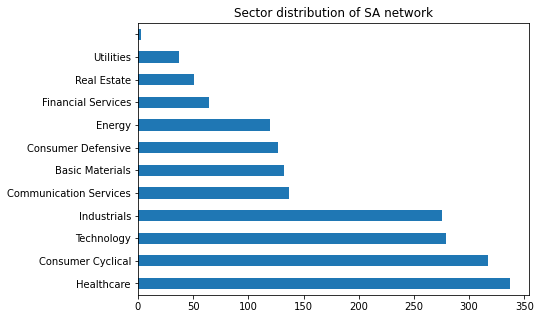

In [9]:
nodes_df['sector'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('Sector distribution of SA network')
plt.show()

Then we can visualize some sector distributions of the largest communities for initially Louvain and Demon.

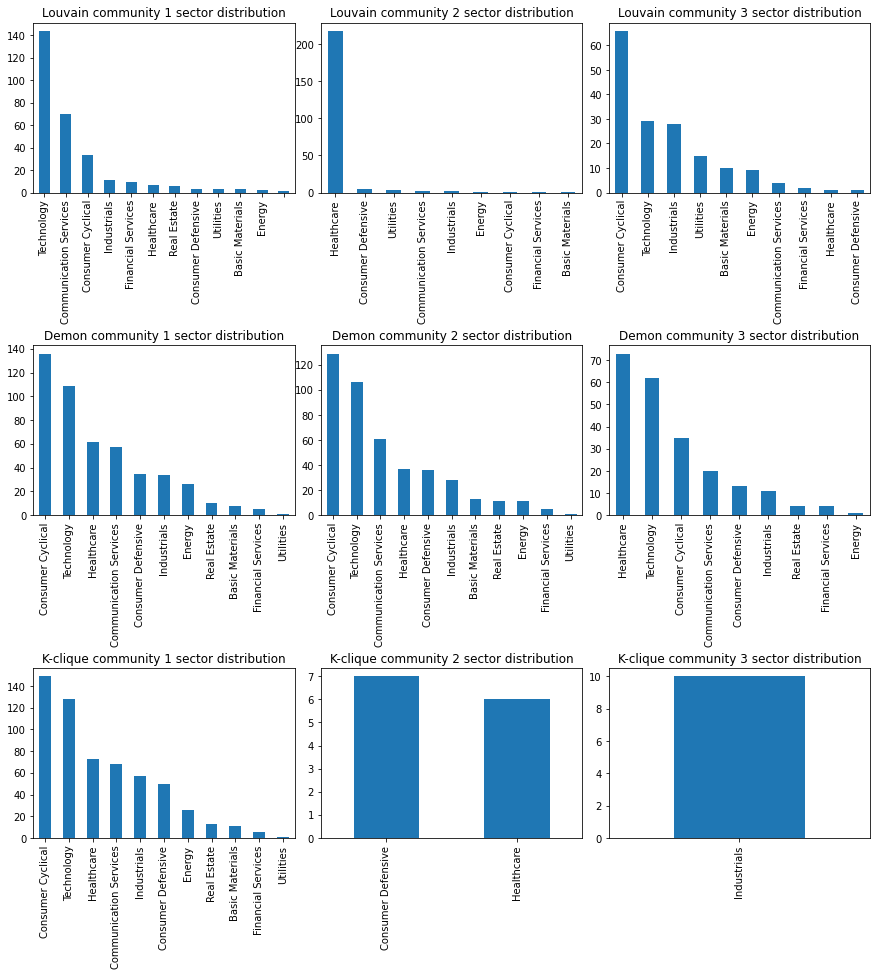

In [10]:
comms_titles = [
    (louvain_comms, 'Louvain'),
    (demon_comms, 'Demon'),
    (kcliq_comms, 'K-clique')
]
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i in range(3):
    for j, (comms, name) in enumerate(comms_titles):
        nodes = comms[i]
        nodes_df.loc[nodes]['sector'].value_counts().plot(kind='bar', ax=axs[j,i])
        axs[j,i].set_title(f'{name} community {i+1} sector distribution')
plt.subplots_adjust(wspace=0.1, hspace=0.9)
plt.show()

It seems that Louvain communities are much better at segmenting out singular sectors from the data. Individual Louvain groups are also larger than those of the Demon communities, showing that the groups of Louvain communities seem to be preferable in this scenario. Also the only Louvain group that has two significant sectors represented has Technology/Communications sectors as the two major sectors, which are sectors highly related to each other.

The k-clique communities also seem to perform worse than the Louvain communities, with the largest community exhibiting quite widely distributed sectors within the community. The second and third communities are only focused within one to two sectors, however, the groups are very small, which could make them less preferable to the Demon/Louvaine communities. It does show, however that k-clique communities seem relatively good at finding small groups with very low sector distribution within them.

Now we can look at the modularity of the produced partition of the Louvain algorithm. It can be calculated using the Louvain package from the produced partition as such:

In [11]:
print(f'Modularity of Louvain partition: {modularity(louvain_comms_dict, G):.3f}')

Modularity of Louvain partition: 0.705


The modularity of the partition does seem quite high, which would indicate that the network is possible to split into a sensible partition, which is in line with the findings of the sector distributions of the Louvain communities.